In [1]:
import os
import numpy as np
from string import Template
import datetime as dt
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import pyproj
from netCDF4 import Dataset

from pynextsim.gmshlib import GmshMesh
from pynextsim.gridding import Grid
from pynextsim.nextsim_config import NextsimConfig
import pynextsim.lib as nsl

import mod_netcdf_utils as mnu

In [2]:
nci_ar = mnu.nc_getinfo('data/aro_eps_20180311.nc') #processed
nci_ar0 = mnu.nc_getinfo('data/aro_eps_2018031100.nc') #raw
nci_ec2 = mnu.nc_getinfo('data/ec2_start20180311.nc')#processed
nci_ec2_0 = mnu.nc_getinfo('data/ec2_raw_20180311.nc')#raw

In [3]:
print(nci_ar.datetimes[0], nci_ar.datetimes[-1])
print(nci_ar0.datetimes[0], nci_ar0.datetimes[-1])
print(nci_ec2.datetimes[0], nci_ec2.datetimes[-1])
print(nci_ec2_0.datetimes[0], nci_ec2_0.datetimes[-1])

2018-03-11 00:00:00 2018-03-13 00:00:00
2018-03-11 03:00:00 2018-03-13 00:00:00
2018-03-11 00:00:00 2018-03-13 21:00:00
2018-03-11 00:00:00 2018-03-11 21:00:00


## AROME on native grid

In [4]:
print(vars(nci_ar.proj_info))
ar_globe = ccrs.Globe(
    semimajor_axis=nci_ar.proj_info.earth_radius,
    semiminor_axis=nci_ar.proj_info.earth_radius,
    )
AR_CRS = ccrs.LambertConformal(
    central_longitude=nci_ar.proj_info.longitude_of_central_meridian,
    central_latitude=nci_ar.proj_info.latitude_of_projection_origin,
    standard_parallels=tuple(nci_ar.proj_info.standard_parallel),
    globe=ar_globe)

{'grid_mapping_name': 'lambert_conformal_conic', 'standard_parallel': array([77.5, 77.5]), 'longitude_of_central_meridian': -25.0, 'latitude_of_projection_origin': 77.5, 'earth_radius': 6371000.0, 'proj4': '+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06'}


In [5]:
AR_DATA = dict()
AR_DATA['x'] = nci_ar.get_dim('x').values
AR_DATA['y'] = nci_ar.get_dim('y').values
AR_DATA['u'] = nci_ar.get_var('x_wind_10m', time_index=1).values
AR_DATA['v'] = nci_ar.get_var('y_wind_10m', time_index=1).values
AR_EXTENT = [AR_DATA['x'][0], AR_DATA['x'][-1], AR_DATA['y'][0], AR_DATA['y'][-1]]

In [27]:
x, y = np.meshgrid(AR_DATA['x'], AR_DATA['y'])
out = EC_CRS.transform_points(AR_CRS, x, y)
AR_LON = out[:,:,0]
AR_LAT = out[:,:,1]
del(out)

In [6]:
AR_DATA0 = dict()
AR_DATA0['x'] = nci_ar0.get_dim('x').values
AR_DATA0['y'] = nci_ar0.get_dim('y').values
with Dataset(nci_ar0.filename, 'r') as ds:
#     print(ds.variables)
    AR_DATA0['u'] = ds.variables['x_wind_10m'][0,0,0,:,:]
    AR_DATA0['v'] = ds.variables['y_wind_10m'][0,0,0,:,:]

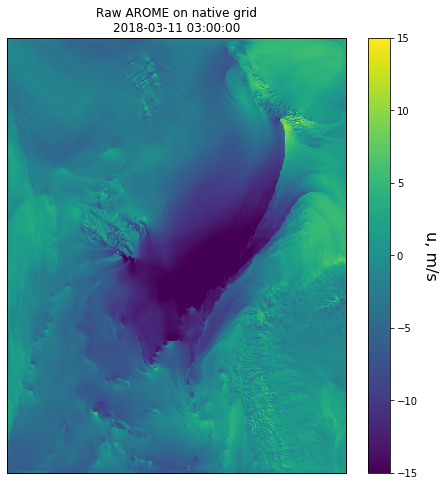

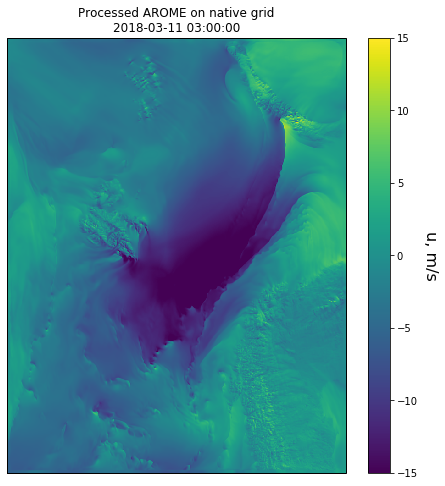

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=AR_CRS, xlim=AR_EXTENT[:2], ylim=AR_EXTENT[2:])
im = ax.imshow(AR_DATA0['u'], clim=[-15,15], extent=AR_EXTENT)
# ax.coastlines(resolution='50m')
cb = fig.colorbar(im)
cb.set_label('u, m/s', rotation=270, labelpad=20, fontsize=16)
ax.set_title(f'Raw AROME on native grid\n{nci_ar0.datetimes[0]}')
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=AR_CRS, xlim=AR_EXTENT[:2], ylim=AR_EXTENT[2:])
im = ax.imshow(AR_DATA['u'], clim=[-15,15], extent=AR_EXTENT)
# ax.coastlines(resolution='50m')
cb = fig.colorbar(im)
cb.set_label('u, m/s', rotation=270, labelpad=20, fontsize=16)
ax.set_title(f'Processed AROME on native grid\n{nci_ar.datetimes[1]}')
plt.show()

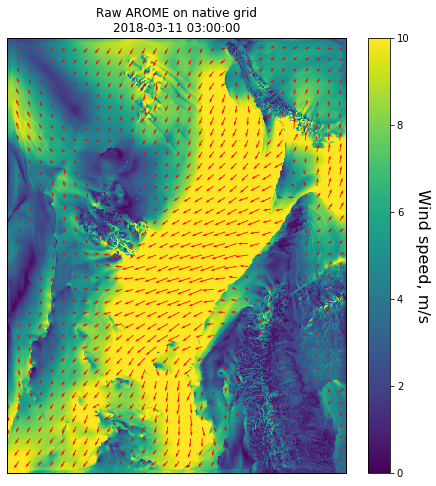

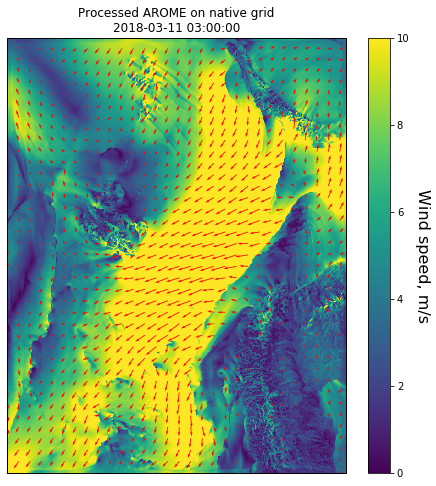

In [8]:
# Raw wind directions
spd = np.hypot(AR_DATA0['u'], AR_DATA0['v'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=AR_CRS, xlim=AR_EXTENT[:2], ylim=AR_EXTENT[2:])
im = ax.imshow(spd, clim=[0,10], extent=AR_EXTENT)
# ax.coastlines(resolution='50m')
cb = fig.colorbar(im)
cb.set_label('Wind speed, m/s', rotation=270, labelpad=20, fontsize=16)
ax.set_title(f'Raw AROME on native grid\n{nci_ar0.datetimes[0]}')

step = 25
x = AR_DATA0['x'][::step]
y = AR_DATA0['y'][::step]
u = AR_DATA0['u'][::step, ::step]
v = AR_DATA0['v'][::step, ::step]
ax.quiver(x, y, u, v,
          units='xy',
          angles='xy',
          color='r')
plt.show()

# Processed wind directions
spd = np.hypot(AR_DATA['u'], AR_DATA['v'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=AR_CRS, xlim=AR_EXTENT[:2], ylim=AR_EXTENT[2:])
im = ax.imshow(spd, clim=[0,10], extent=AR_EXTENT)
# ax.coastlines(resolution='50m')
cb = fig.colorbar(im)
cb.set_label('Wind speed, m/s', rotation=270, labelpad=20, fontsize=16)
ax.set_title(f'Processed AROME on native grid\n{nci_ar.datetimes[1]}')

step = 25
x = AR_DATA['x'][::step]
y = AR_DATA['y'][::step]
u = AR_DATA['u'][::step, ::step]
v = AR_DATA['v'][::step, ::step]
ax.quiver(x, y, u, v,
          units='xy',
          angles='xy',
          color='r')
plt.show()

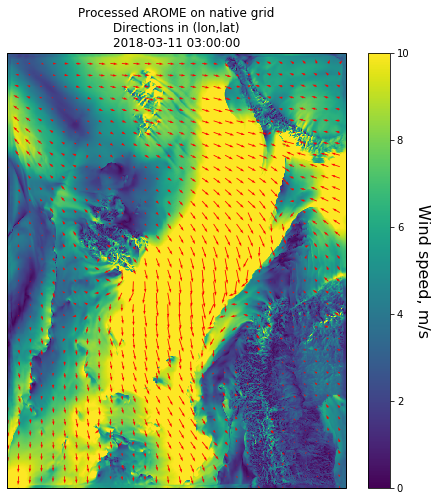

In [30]:
# Processed wind directions with lon,lat directions
spd = np.hypot(AR_DATA['u'], AR_DATA['v'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=AR_CRS, xlim=AR_EXTENT[:2], ylim=AR_EXTENT[2:])
im = ax.imshow(spd, clim=[0,10], extent=AR_EXTENT)
# ax.coastlines(resolution='50m')
cb = fig.colorbar(im)
cb.set_label('Wind speed, m/s', rotation=270, labelpad=20, fontsize=16)
ax.set_title(f'Processed AROME on native grid\nDirections in (lon,lat)\n{nci_ar.datetimes[1]}')

step = 25
lon = AR_LON[::step, ::step]
lat = AR_LAT[::step, ::step]
u = AR_DATA['u'][::step, ::step]
v = AR_DATA['v'][::step, ::step]
ax.quiver(lon, lat, u, v,
          units='xy',
          angles='xy',
          color='r',
          transform=EC_CRS,
         )
plt.show()

## ECMWF in AROME projection

In [9]:
def extend_lim(lim, fac=1):
    av = .5*(lim[1] + lim[0])
    r = .5*(lim[1] - lim[0])
    return av - fac*r, av + fac*r

In [10]:
EC_CRS = ccrs.PlateCarree()
EC_DATA = dict()
EC_DATA['lon'], EC_DATA['lat'] = nci_ec2.get_lonlat(vec2mat=False)
EC_DATA['u'] = nci_ec2.get_var('10U', time_index=1).values
EC_DATA['v'] = nci_ec2.get_var('10V', time_index=1).values
EC_EXTENT = [EC_DATA['lon'][0], EC_DATA['lon'][-1], EC_DATA['lat'][0], EC_DATA['lat'][-1]]

In [11]:
EC_DATA0 = dict()
EC_DATA0['lon'], EC_DATA0['lat'] = nci_ec2_0.get_lonlat(vec2mat=False)
EC_DATA0['u'] = nci_ec2_0.get_var('u10', time_index=1).values
EC_DATA0['v'] = nci_ec2_0.get_var('v10', time_index=1).values
EC_EXTENT0 = [EC_DATA0['lon'][0], EC_DATA0['lon'][-1], EC_DATA0['lat'][0], EC_DATA0['lat'][-1]]

/home/timill/Packages/python/miniconda2/envs/pynextsim/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


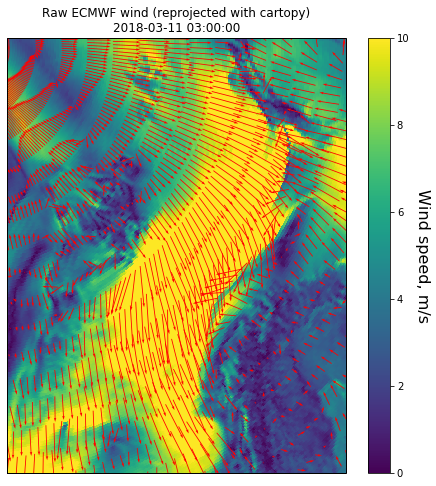

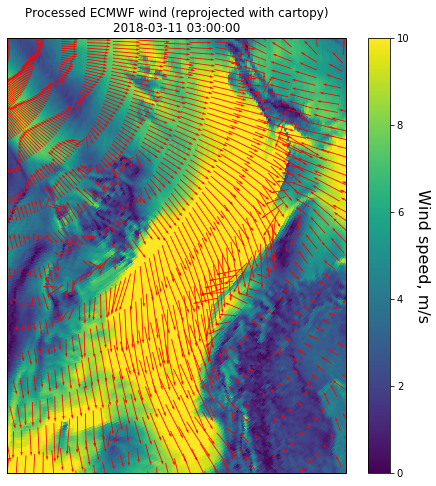

In [12]:
# raw on AROME domain
spd = np.hypot(EC_DATA0['u'], EC_DATA0['v'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=AR_CRS,
                     xlim=extend_lim(AR_EXTENT[:2]),
                     ylim=extend_lim(AR_EXTENT[2:]),
                    )
im = ax.imshow(spd, clim=[0,10], extent=EC_EXTENT0, transform=EC_CRS)
cb = fig.colorbar(im)
cb.set_label('Wind speed, m/s', rotation=270, labelpad=20, fontsize=16)

ax.set_title(f'Raw ECMWF wind (reprojected with cartopy)\n{nci_ec2.datetimes[1]}')
step = 10
lon, lat = np.meshgrid(EC_DATA0['lon'][::step], EC_DATA0['lat'][::step])
u = EC_DATA0['u'][::step, ::step]
v = EC_DATA0['v'][::step, ::step]
ax.quiver(lon, lat, u, v,
#           units='xy',
          angles='xy',
          scale_units='width',
          scale=1e2,
          color='r', transform=EC_CRS)
plt.show()

# processed on AROME domain
spd = np.hypot(EC_DATA['u'], EC_DATA['v'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=AR_CRS,
                     xlim=extend_lim(AR_EXTENT[:2]),
                     ylim=extend_lim(AR_EXTENT[2:]),
                    )
im = ax.imshow(spd, clim=[0,10], extent=EC_EXTENT, transform=EC_CRS)
cb = fig.colorbar(im)
cb.set_label('Wind speed, m/s', rotation=270, labelpad=20, fontsize=16)

ax.set_title(f'Processed ECMWF wind (reprojected with cartopy)\n{nci_ec2.datetimes[1]}')
step = 10
lon, lat = np.meshgrid(EC_DATA['lon'][::step], EC_DATA['lat'][::step])
u = EC_DATA['u'][::step, ::step]
v = EC_DATA['v'][::step, ::step]
ax.quiver(lon, lat, u, v,
#           units='xy',
          angles='xy',
          scale_units='width',
          scale=1e2,
          color='r', transform=EC_CRS)
plt.show()

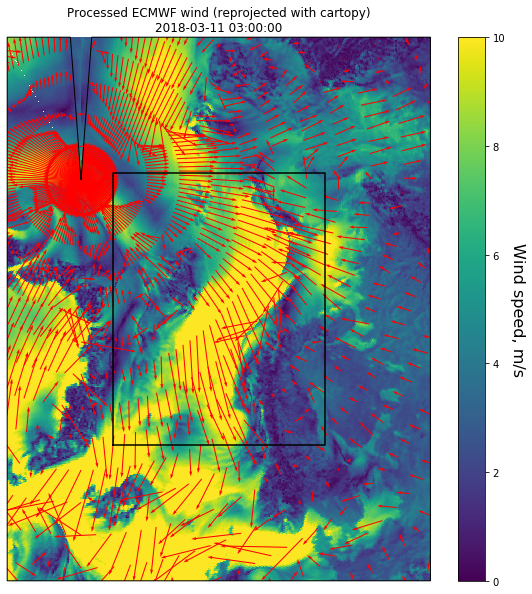

In [13]:
# zoom out
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=AR_CRS,
                     xlim=extend_lim(AR_EXTENT[:2], fac=2),
                     ylim=extend_lim(AR_EXTENT[2:], fac=2),
                    )
im = ax.imshow(spd, clim=[0,10], extent=EC_EXTENT, transform=EC_CRS)
cb = fig.colorbar(im)
cb.set_label('Wind speed, m/s', rotation=270, labelpad=20, fontsize=16)
ax.set_title(f'Processed ECMWF wind (reprojected with cartopy)\n{nci_ec2.datetimes[1]}')

xbox = [AR_EXTENT[0], AR_EXTENT[1], AR_EXTENT[1], AR_EXTENT[0], AR_EXTENT[0]]
ybox = [AR_EXTENT[2], AR_EXTENT[2], AR_EXTENT[3], AR_EXTENT[3], AR_EXTENT[2]]
ax.plot(xbox, ybox, 'k')

step = 20
lon, lat = np.meshgrid(EC_DATA['lon'][::step], EC_DATA['lat'][::step])
u = EC_DATA['u'][::step, ::step]
v = EC_DATA['v'][::step, ::step]
ax.quiver(lon, lat, u, v,
#           units='xy',
          angles='xy',
          scale_units='width',
          scale=1e2,
          color='r', transform=EC_CRS)
plt.show()